We will be using Keras with TensorFlow backend to train a fashion product classifier uisng [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## for working on multi-user GPU station
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
config.gpu_options.visible_device_list = "4"
set_session(tf.Session(config=config))

Using TensorFlow backend.


### Load Data
Keras provides API to download Fashion-MNIST dataset

In [2]:
from keras.datasets import fashion_mnist
(image_train, label_train), (image_test, label_test) = fashion_mnist.load_data()

The data have been downloaded in your system. Here is the [references to the classes labels](https://keras.io/datasets/#fashion-mnist-database-of-fashion-articles)

In [3]:
# build a dictionary for easy access to object classes
objects = {0: 'T-shirt/top',
           1: 'Trouser',
           2: 'Pullover',
           3: 'Dress',
           4: 'Coat',
           5: 'Sandal',
           6: 'Shirt',
           7: 'Sneaker',
           8: 'Bag',
           9: 'Ankle boot'}

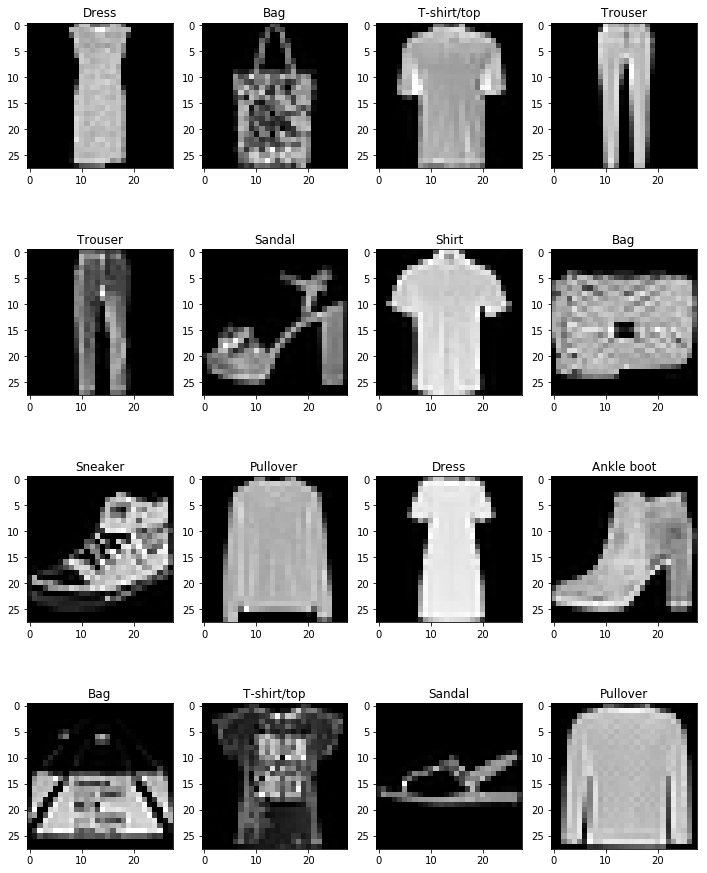

In [4]:
def data_visualize(images, labels, n_rows=3, n_cols=3):
    f, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_rows*3, n_cols*4))
    for axe in axes:
        for axe_plot in axe:
            i = np.random.randint(0, len(images))
            axe_plot.imshow(images[i], cmap='gray')
            axe_plot.set_title(objects[labels[i]])
data_visualize(image_train, label_train, 4, 4)

#### Data Augmentation

To obtain "more data" to feed our NN, we simply flip images horizentally to double the number of images

In [5]:
image_train_flip = np.array([np.fliplr(img) for img in image_train])

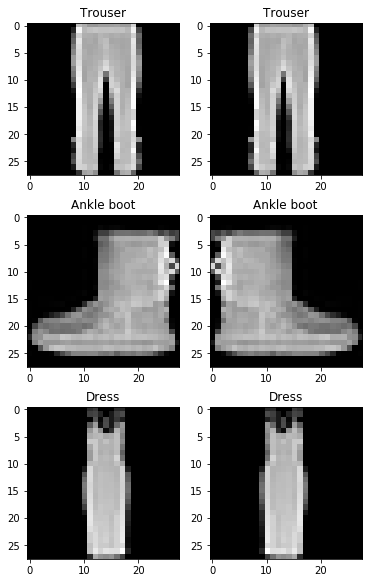

In [6]:
_, axes = plt.subplots(nrows=3, ncols=2, figsize=(6, 10))
for axe in axes:
    i = np.random.randint(0, len(image_train))
    axe[0].imshow(image_train[i], cmap='gray')
    axe[0].set_title(objects[label_train[i]])
    axe[1].imshow(image_train_flip[i], cmap='gray')
    axe[1].set_title(objects[label_train[i]])

### Prepare data for training

In [7]:
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

x_train = np.concatenate((image_train, image_train_flip), axis=0)
y_train = np.concatenate((label_train, label_train), axis=0)

x_train = x_train.reshape((x_train.shape[0], 28, 28, 1)) # (batch_size, height, width, channels)
y_train = to_categorical(y_train) # one-hot encoding

In [8]:

# divide into training, validation, test split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True)
print('x_train shape: {}; y_train shape: {}'.format(x_train.shape, y_train.shape))
print('x_val shape: {}; y_val shape: {}'.format(x_val.shape, y_val.shape))
print('image_test shape: {}; label_test shape: {}'.format(image_test.shape, label_test.shape))

x_train shape: (96000, 28, 28, 1); y_train shape: (96000, 10)
x_val shape: (24000, 28, 28, 1); y_val shape: (24000, 10)
image_test shape: (10000, 28, 28); label_test shape: (10000,)


### build model

In [9]:
from keras.models import Model, load_model
from keras.layers import Dense, Dropout, Flatten, Reshape, Input, BatchNormalization, Conv2D, MaxPooling2D
from keras import regularizers
from keras.callbacks import ModelCheckpoint

In [28]:
# hyperparameters
epochs = 30
batch_size = 256

def get_model(input_shape):
    
    drop = 0.35
    # l2 regularization as well as dropout can help prevent overfitting
#     l2_reg = regularizers.l2(0.01)
    
    X_input = Input(input_shape)
    X = BatchNormalization()(X_input) # normalize input 
    
    X = Conv2D(64, (5,5), strides=(1,1), activation='relu')(X)
#                kernel_regularizer=l2_reg,
#                bias_initializer='RandomNormal',
#                kernel_initializer='random_uniform')(X)
    X = MaxPooling2D((2,2))(X)
    
    
    X = Conv2D(512, (5,5), strides=(1,1), activation='relu')(X)
#                kernel_regularizer=l2_reg)(X)
#                kernel_initializer='random_uniform')(X)
    X = MaxPooling2D((2,2))(X)    

    
    X = Flatten()(X)
    
#     X = BatchNormalization()(X)
    X = Dense(128, activation='relu')(X)
#               kernel_regularizer=l2_reg)(X)
    X = Dropout(drop)(X)
    
    X = Dense(64, activation='relu')(X)
    X = Dropout(drop)(X)
    

    X = Dense(10, activation='softmax')(X)
    
    model = Model(inputs=[X_input], outputs=[X])
    
    return model

model = get_model((28, 28, 1))

# compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 64)        1664      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 512)         819712    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 512)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
__________

### Training

In [30]:
f_path = 'model_fashion.h5'
msave = ModelCheckpoint(f_path, save_best_only=True)

In [35]:
training = model.fit(x_train, y_train,
                     validation_data=(x_val, y_val),
                     epochs=epochs,
                     callbacks = [msave],
                     batch_size=batch_size, 
                     verbose=1)

Train on 96000 samples, validate on 24000 samples
Epoch 1/30
96000/96000 [==============================] - 6s 59us/step - loss: 0.1362 - acc: 0.9510 - val_loss: 0.2064 - val_acc: 0.9296
Epoch 2/30
96000/96000 [==============================] - 5s 52us/step - loss: 0.1270 - acc: 0.9537 - val_loss: 0.2014 - val_acc: 0.9319
Epoch 3/30
96000/96000 [==============================] - 5s 53us/step - loss: 0.1158 - acc: 0.9589 - val_loss: 0.2122 - val_acc: 0.9331
Epoch 4/30
96000/96000 [==============================] - 5s 54us/step - loss: 0.1074 - acc: 0.9615 - val_loss: 0.2356 - val_acc: 0.9293
Epoch 5/30
96000/96000 [==============================] - 5s 54us/step - loss: 0.1018 - acc: 0.9626 - val_loss: 0.2256 - val_acc: 0.9327
Epoch 6/30
96000/96000 [==============================] - 5s 53us/step - loss: 0.0995 - acc: 0.9642 - val_loss: 0.2362 - val_acc: 0.9356
Epoch 7/30
96000/96000 [==============================] - 5s 52us/step - loss: 0.0887 - acc: 0.9678 - val_loss: 0.2362 - val_acc

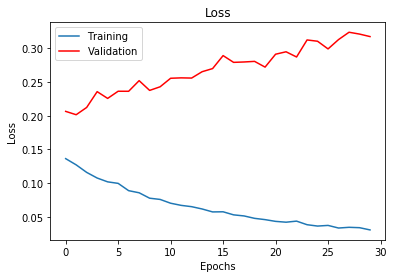

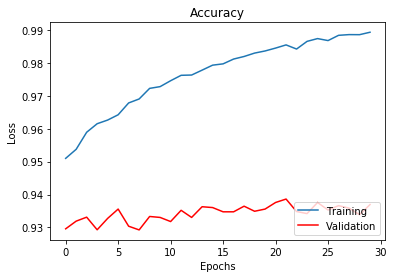

In [36]:
# show the loss and accuracy
loss = training.history['loss']
val_loss = training.history['val_loss']
acc = training.history['acc']
val_acc = training.history['val_acc']

# loss plot
tra = plt.plot(loss)
val = plt.plot(val_loss, 'r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend(["Training", "Validation"])

plt.show()

# accuracy plot
plt.plot(acc)
plt.plot(val_acc, 'r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Accuracy')
plt.legend(['Training', 'Validation'], loc=4)
plt.show()

### Evaluation using reserved test set

In [37]:
x_test = image_test.reshape((image_test.shape[0], 28, 28, 1))
y_test = label_test
from sklearn.metrics import accuracy_score
model = load_model(f_path)
pred = model.predict(x_test)
# convert predicions from categorical back to 0...9 digits
pred_digits = np.argmax(pred, axis=1)

accuracy_score(y_test, pred_digits)

0.917

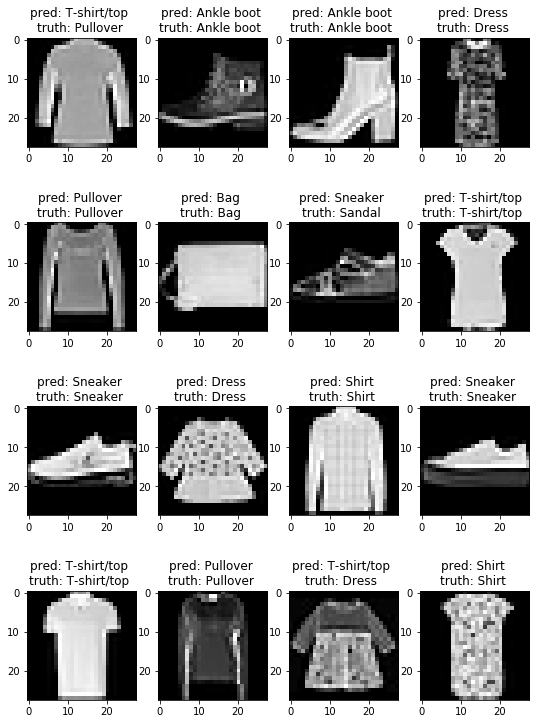

In [18]:
def predict(imgs, model):
    if imgs.shape == (28,28):
        imgs = imgs.reshape((1, 28, 28, 1))
    else:
        imgs = imgs.reshape((imgs.shape[0], 28, 28, 1))
    
    preds = model.predict(imgs)
    return np.argmax(preds, axis=1)[0]

def visual_preds(test_imgs, test_labels, model):
    f, axes = plt.subplots(nrows=4, ncols=4, figsize=(9, 13))
    for axe in axes:
        for axe_plot in axe:
            i = np.random.randint(0, len(test_imgs))
            axe_plot.imshow(test_imgs[i], cmap='gray')
            axe_plot.set_title('pred: {} \ntruth: {} '.format(objects[predict(test_imgs[i], model)], objects[test_labels[i]]))
            
visual_preds(image_test, label_test, model)